In [43]:
#import pip
#import sys
#pip install plotly
#pip install opencv-python
#pip install scikit_posthocs

In [44]:
import numpy as np
import plotly
import imageio.v2 as imageio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
import cv2 
from skimage import img_as_ubyte
from skimage import exposure
from skimage.color import rgb2gray
from skimage import data, filters, measure, morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import difference_of_gaussians, gaussian, threshold_local, threshold_yen
from skimage.morphology import square, disk
import scipy.stats as ss # for statistical testing
import scikit_posthocs as sp # for posthoc testing



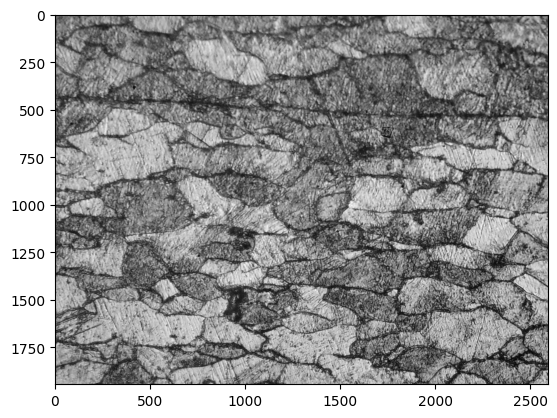

In [45]:
imagename = 'sample2_2' #change here the file name
image1 = cv2.imread(imagename+'.jpg')
#img_grey= cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY )
plt.imshow(img_grey, cmap='gray')

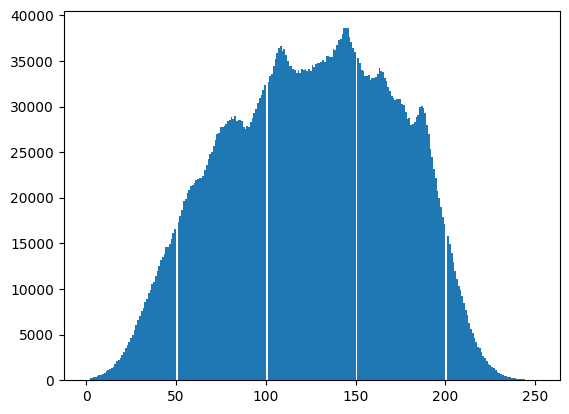

In [46]:
plt.hist(img_grey.ravel(), bins=256)
plt.show()

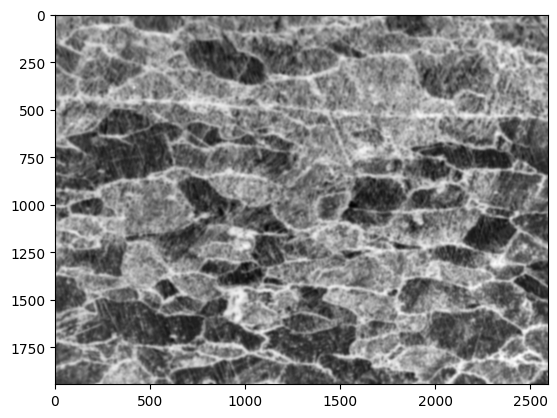

In [47]:
img_inv = 255-img_grey
img_gaus= gaussian(img_inv, sigma=5)
plt.imshow(img_gaus, cmap='gray')

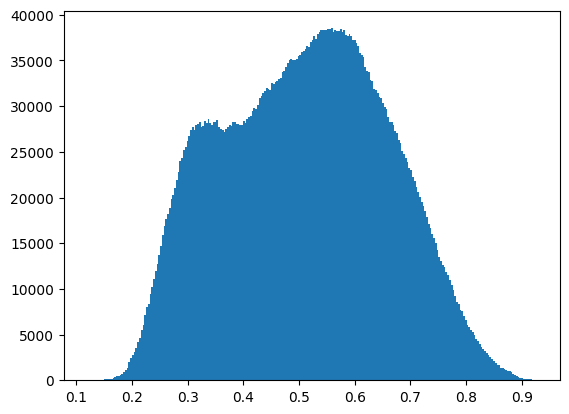

In [48]:
plt.hist(img_gaus.ravel(), bins=256)
plt.show()

[[0.58095787 0.58094131 0.58090821 ... 0.55846451 0.55854278 0.55858194]
 [0.58094345 0.58092689 0.58089379 ... 0.55845356 0.55853181 0.55857096]
 [0.58091464 0.58089808 0.580865   ... 0.55843167 0.55850987 0.558549  ]
 ...
 [0.37854419 0.37854947 0.37856004 ... 0.44849006 0.44840334 0.44835996]
 [0.378452   0.3784573  0.37846789 ... 0.44834573 0.44825891 0.44821548]
 [0.37840588 0.37841119 0.37842179 ... 0.44827353 0.44818666 0.44814321]]


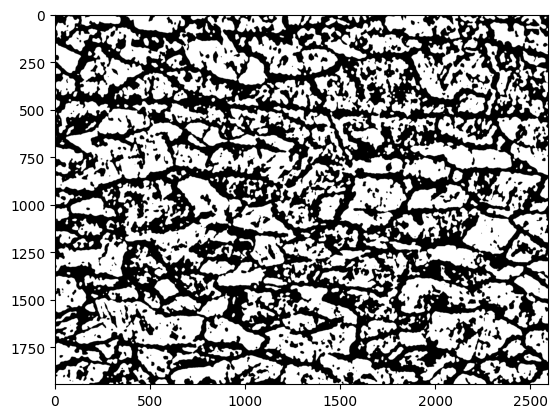

In [49]:
block_size = 251
threshold = threshold_local(img_gaus, block_size)

#threshold = filters.threshold_yen(img_gaus)
print(threshold)
mask = img_gaus < threshold *1
plt.imshow(mask, cmap='gray')

,area,perimeter,eccentricity,solidity
0,259.0,73.834524,0.912275,0.899306
1,58.0,29.485281,0.837575,0.950820
2,9281.0,596.161472,0.969127,0.789805
3,20920.0,1015.026479,0.943778,0.866468
4,2063.0,212.468037,0.942258,0.930537
...,...,...,...,...
348,1364.0,166.361436,0.915249,0.956522
349,110.0,38.727922,0.670256,0.956522
350,147.0,53.313708,0.940989,0.936306
351,38.0,25.656854,0.953538,0.904762


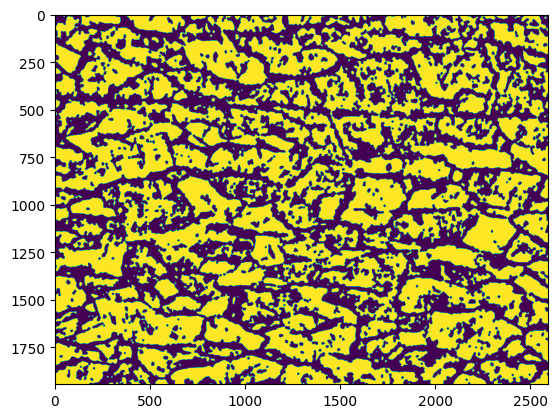

In [50]:

mask1 = morphology.remove_small_objects(mask, min_size=5000)
mask1 = morphology.remove_small_holes(mask, area_threshold=10000)
mask1 = morphology.closing(mask,disk(5))

labels = measure.label(mask1)
plt.imshow(mask1)
props1 = regionprops_table(labels, properties=('area','perimeter','eccentricity','solidity'))
pd.DataFrame(props1)


In [51]:
fig = px.imshow(img_grey, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img_grey)
properties = ['area','perimeter','eccentricity','solidity']

for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

fig.write_html(imagename+"segmentation.html")

In [52]:
pics = ['X6_1', 'X6_2', 'X6_3', 'X6_4', 'X6_5', 'X19_1', 'X19_2', 'X19_3', 'X19_4', 'X19_5', 'X28_1', 'X28_2', 'X28_3', 'X28_4', 'X28_5']
for i in pics:
    imagename = i 
    dataframe = pd.DataFrame(props1)
    dataframe.to_csv(imagename+'shapedata.csv', encoding='utf-8', index=False)

In [53]:
filename1_1 = 'X6_1shapedata.csv' 
filename2_1 = 'X6_2shapedata.csv' 
filename3_1 = 'X6_3shapedata.csv' 
filename4_1 = 'X6_4shapedata.csv' 
filename5_1 = 'X6_5shapedata.csv' 

filename1_2 = 'X6_1shapedata.csv' 
filename2_2 = 'X6_2shapedata.csv' 
filename3_2 = 'X6_3shapedata.csv' 
filename4_2 = 'X6_4shapedata.csv' 
filename5_2 = 'X6_5shapedata.csv' 

filename1_3 = 'X6_1shapedata.csv' 
filename2_3 = 'X6_2shapedata.csv' 
filename3_3 = 'X6_3shapedata.csv' 
filename4_3 = 'X6_4shapedata.csv' 
filename5_3 = 'X6_5shapedata.csv' 


df1_1 = pd.read_csv(filename1_1)
df2_1 = pd.read_csv(filename2_1)
df3_1 = pd.read_csv(filename3_1)
df4_1 = pd.read_csv(filename4_1)
df5_1 = pd.read_csv(filename5_1)

df1_2 = pd.read_csv(filename1_2)
df2_2 = pd.read_csv(filename2_2)
df3_2 = pd.read_csv(filename3_2)
df4_2 = pd.read_csv(filename4_2)
df5_2 = pd.read_csv(filename5_2)

df1_3 = pd.read_csv(filename1_3)
df2_3 = pd.read_csv(filename2_3)
df3_3 = pd.read_csv(filename3_3)
df4_3 = pd.read_csv(filename4_3)
df5_3 = pd.read_csv(filename5_3)


In [54]:
allMat1=pd.concat([df1_1,df2_1,df3_1,df4_1, df5_1]) #etc. in your case it would be including also df5, df6
# allMat2 would then include df7-df12; allMat3 would include df13-df18
allMat2=pd.concat([df1_2,df2_2,df3_2,df4_2, df5_2])

allMat3=pd.concat([df1_3,df2_3,df3_3,df4_3, df5_3])

In [55]:
Areas=[allMat1["area"],allMat2["area"],allMat3["area"]]
Perimeter=[allMat1["perimeter"],allMat2["perimeter"],allMat2["perimeter"]]
Eccentricities=[allMat1["eccentricity"],allMat2["eccentricity"],allMat2["eccentricity"]]
Solidity=[allMat1["solidity"],allMat2["solidity"],allMat2["solidity"]]

In [56]:
for df in Areas:
    print(df.sum(),df.mean(),df.std(),df.count()) 

13925240.0 7889.654390934844 28437.71829917137 1765
13925240.0 7889.654390934844 28437.71829917137 1765
13925240.0 7889.654390934844 28437.71829917137 1765


In [57]:
for df in Perimeter:
    print(df.sum(),df.mean(),df.std(),df.count()) 

989043.6258203477 560.3646605214434 1865.1924014392134 1765
989043.6258203477 560.3646605214434 1865.1924014392134 1765
989043.6258203477 560.3646605214434 1865.1924014392134 1765


In [58]:
for df in Solidity:
    print(df.mean(),df.std(),df.count()) 

0.853996398270107 0.1474902448897028 1765
0.853996398270107 0.1474902448897028 1765
0.853996398270107 0.1474902448897028 1765


In [59]:
for df in Eccentricities:
    print(df.mean(),df.std(),df.count()) 

0.7612322129379531 0.1997576951333533 1765
0.7612322129379531 0.1997576951333533 1765
0.7612322129379531 0.1997576951333533 1765


{'whiskers': [<matplotlib.lines.Line2D at 0x1ccdb54e410>,
 'caps': [<matplotlib.lines.Line2D at 0x1ccdb54fbd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ccdb54db50>,
 'medians': [<matplotlib.lines.Line2D at 0x1ccdb545490>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ccdb546390>,
 'means': [<matplotlib.lines.Line2D at 0x1ccdb5458d0>,
  <matplotlib.lines.Line2D at 0x1ccdbaf47d0>]}

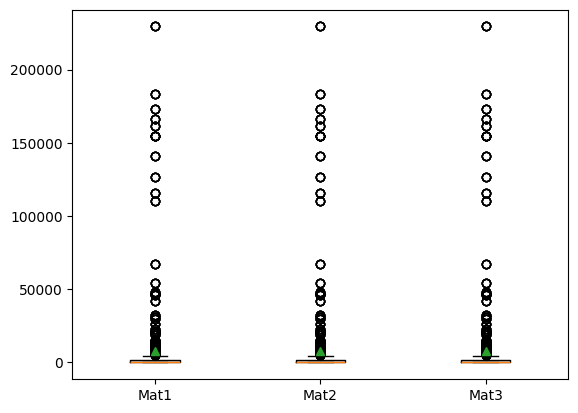

In [60]:
plt.boxplot(Areas, labels=['Mat1', 'Mat2', 'Mat3'], showmeans=True)

In [61]:
h, w = mask1.shape
totalArea=h*w
Sum_Mat1_SegmentArea=(sum(allMat1.area))/4 #divide by number of images that were analysed
Fraction_Mat1_SegmentArea=Sum_Mat1_SegmentArea/totalArea
Sum_Mat2_SegmentArea=(sum(allMat2.area))/4 #divide by number of images that were analysed
Fraction_Mat2_SegmentArea=Sum_Mat2_SegmentArea/totalArea
print(totalArea)
print([Sum_Mat1_SegmentArea,Sum_Mat2_SegmentArea])
print([Fraction_Mat1_SegmentArea,Fraction_Mat2_SegmentArea])

5038848
[3481310.0, 3481310.0]
[0.6908940297464817, 0.6908940297464817]


In [62]:
h, w = mask1.shape
totalArea=h*w

Sum_Mat1_1_SegmentArea=(sum(df1_1.area))
Fraction_Mat1_1_SegmentArea=Sum_Mat1_1_SegmentArea/totalArea

Sum_Mat1_2_SegmentArea=(sum(df2_1.area))
Fraction_Mat1_2_SegmentArea=Sum_Mat1_2_SegmentArea/totalArea

Sum_Mat1_3_SegmentArea=(sum(df3_1.area))
Fraction_Mat1_3_SegmentArea=Sum_Mat1_3_SegmentArea/totalArea

Sum_Mat1_4_SegmentArea=(sum(df4_1.area))
Fraction_Mat1_4_SegmentArea=Sum_Mat1_4_SegmentArea/totalArea

Sum_Mat1_5_SegmentArea=(sum(df5_1.area))
Fraction_Mat1_5_SegmentArea=Sum_Mat1_5_SegmentArea/totalArea

Sum_Mat1_SegmentArea=[Sum_Mat1_1_SegmentArea,Sum_Mat1_2_SegmentArea,Sum_Mat1_3_SegmentArea,Sum_Mat1_4_SegmentArea,Sum_Mat1_5_SegmentArea]
Fraction_Mat1_SegmentArea=[Fraction_Mat1_1_SegmentArea,Fraction_Mat1_2_SegmentArea,Fraction_Mat1_3_SegmentArea,Fraction_Mat1_4_SegmentArea,Fraction_Mat1_5_SegmentArea]

#same for Material 2

Sum_Mat2_1_SegmentArea=(sum(df1_2.area))
Fraction_Mat2_1_SegmentArea=Sum_Mat2_1_SegmentArea/totalArea

Sum_Mat2_2_SegmentArea=(sum(df2_2.area))
Fraction_Mat2_2_SegmentArea=Sum_Mat2_2_SegmentArea/totalArea

Sum_Mat2_3_SegmentArea=(sum(df3_2.area))
Fraction_Mat2_3_SegmentArea=Sum_Mat2_3_SegmentArea/totalArea

Sum_Mat2_4_SegmentArea=(sum(df4_2.area))
Fraction_Mat2_4_SegmentArea=Sum_Mat2_4_SegmentArea/totalArea

Sum_Mat2_5_SegmentArea=(sum(df5_2.area))
Fraction_Mat2_5_SegmentArea=Sum_Mat2_5_SegmentArea/totalArea

Sum_Mat2_SegmentArea=[Sum_Mat2_1_SegmentArea,Sum_Mat2_2_SegmentArea,Sum_Mat2_3_SegmentArea,Sum_Mat2_4_SegmentArea,Sum_Mat2_5_SegmentArea]
Fraction_Mat2_SegmentArea=[Fraction_Mat2_1_SegmentArea,Fraction_Mat2_2_SegmentArea,Fraction_Mat2_3_SegmentArea,Fraction_Mat2_4_SegmentArea,Fraction_Mat2_5_SegmentArea]

#same for Material 3

Sum_Mat3_1_SegmentArea=(sum(df1_3.area))
Fraction_Mat3_1_SegmentArea=Sum_Mat3_1_SegmentArea/totalArea

Sum_Mat3_2_SegmentArea=(sum(df2_3.area))
Fraction_Mat3_2_SegmentArea=Sum_Mat3_2_SegmentArea/totalArea

Sum_Mat3_3_SegmentArea=(sum(df3_3.area))
Fraction_Mat3_3_SegmentArea=Sum_Mat3_3_SegmentArea/totalArea

Sum_Mat3_4_SegmentArea=(sum(df4_3.area))
Fraction_Mat3_4_SegmentArea=Sum_Mat3_4_SegmentArea/totalArea

Sum_Mat3_5_SegmentArea=(sum(df5_3.area))
Fraction_Mat3_5_SegmentArea=Sum_Mat3_5_SegmentArea/totalArea

Sum_Mat3_SegmentArea=[Sum_Mat3_1_SegmentArea,Sum_Mat3_2_SegmentArea,Sum_Mat3_3_SegmentArea,Sum_Mat3_4_SegmentArea,Sum_Mat3_5_SegmentArea]
Fraction_Mat3_SegmentArea=[Fraction_Mat3_1_SegmentArea,Fraction_Mat3_2_SegmentArea,Fraction_Mat3_3_SegmentArea,Fraction_Mat3_4_SegmentArea,Fraction_Mat3_5_SegmentArea]



In [63]:
plt.boxplot(Fractions_Areas, labels=['Mat1', 'Mat2', 'Mat3'], showmeans=True)

NameError: name 'Fractions_Areas' is not defined

In [ ]:
ss.f_oneway(allMat1["area"],allMat2["area"],allMat3["area"]) 

F_onewayResult(statistic=-2.8634679410554125e-30, pvalue=nan)

In [ ]:
sp.posthoc_mannwhitney(Areas, p_adjust = 'bonferroni')

,1,2,3
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
